In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import lightkurve as lk
import warnings
warnings.filterwarnings("ignore")

In [26]:
def search(periodogram, left_perc, right_perc):
    max_p = 0
    ass_p = 0
    periods = periodogram.period.value
    powers = periodogram.power.value
    print(periods, powers)
    delta = periods[len(periods)-1] - periods[0]
    left = periods[0] + delta*left_perc
    right = periods[len(periods)-1] - delta*right_perc
    for i in range(1,len(periods)):
        if(periods[i] > left and periods[i] < right):
            if(powers[i] > max_p):
                max_p = powers[i]
                ass_p = periods[i]
    return ass_p

In [31]:
def preprocess(data):
    with open('time.npy', 'rb') as f:
        time_x = np.load(f, allow_pickle = True) #bkjd != jd FIX TODO
    
    #initialize matrix
    features = np.zeros(shape=(len(data),3197))
    percent = 0
    for i in range(30,len(features)): 
        #create light curve for each sample
        lc = lk.LightCurve(time=time_x[:3197], flux=np.array(data[i,1:]).flatten())
        lc.scatter()
        
        lc = lc.flatten()
        
        lc_temp, bool_mask = lc.remove_outliers(return_mask=True) #get bool array of outliers
        #print(np.count_nonzero(bool_mask))
        median = np.median(lc.flux)
        replica = lc.flux
        replica[bool_mask] = median #fil outliers with median
        lc.scatter()
        
        lc = lc.normalize(unit='ppm') #normalize
        lc.scatter()
        
        periodogram = lc.to_periodogram("bls")
        periodogram.plot()
        
        period = search(periodogram, .01, .01)
        print(period)
        lc = lc.fold(period)
        features[i,:] = lc.flux
        lc.scatter()
        
        if(((i / len(features)) * 100) > percent):
            print(percent, "%")
            percent += 1
        break
    return features

[ 0.35043168  0.35044261  0.35045355 ... 24.87300945 24.9282375
 24.98371135] [2.90807629e+11 1.98143857e+11 1.69522593e+11 ... 1.16877402e+11
 1.19410601e+11 1.10713703e+11]
8.626997970698374
0 %


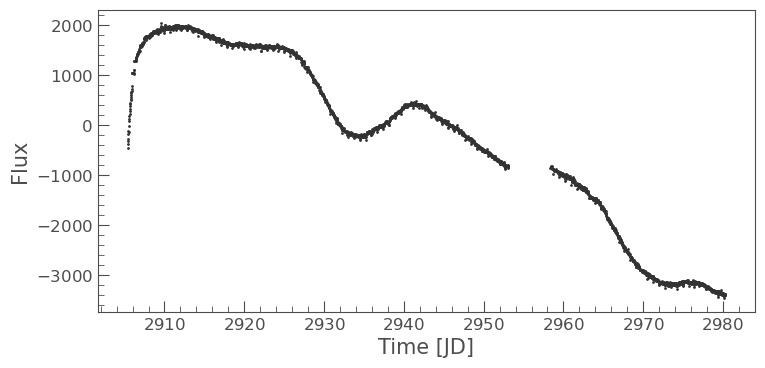

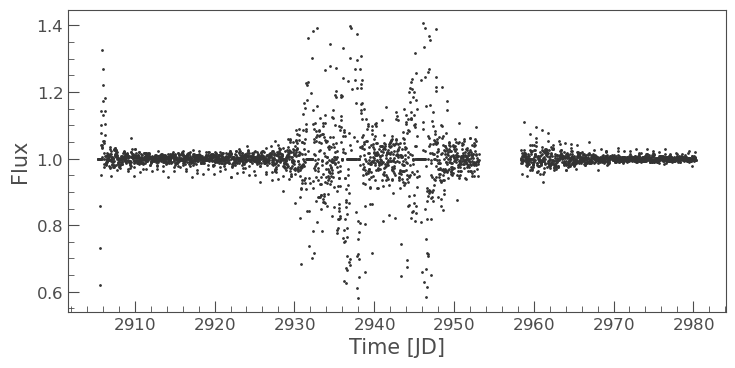

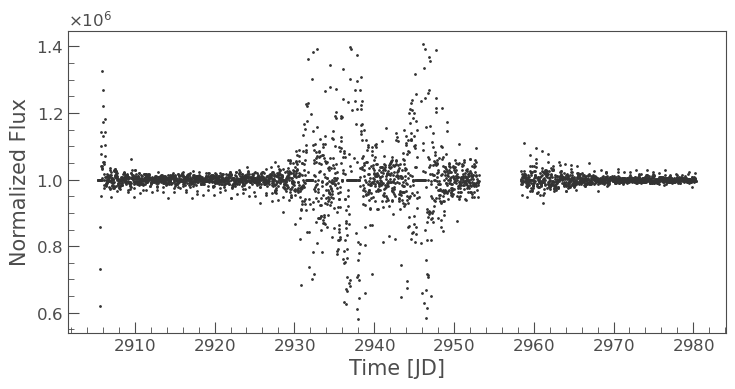

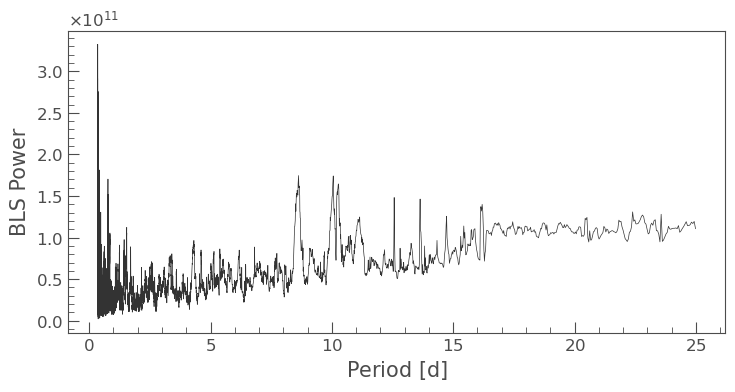

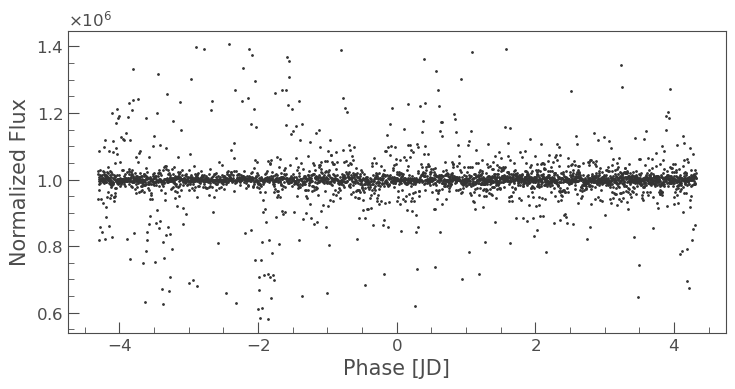

In [32]:
train_data = np.matrix(pd.read_csv("../archive/exoTrain.csv").values)
training_data_y = train_data[:,0] - 1
training_data_x = preprocess(train_data)

with open('../archive/clean-exo-train.npy', 'wb') as f:
    np.save(f, training_data_x)
    np.save(f, training_data_y)

In [ ]:
test_data = np.matrix(pd.read_csv("../archive/exoTest.csv").values)
testing_data_y = test_data[:,0] - 1
testing_data_x = preprocessing(test_data)
    
with open('../archive/clean-exo-test.npy', 'wb') as f:
    np.save(f, testing_data_x)
    np.save(f, testing_data_y)